This notebook runs the text summerizer on Amazon dataset using Gated Recurrent Units architecture in Recurrent Neural Networks.
Dataset size : 20000

Installing necessary librabries.

We have downgraded Keras and Tensorflow as were facing an issue during inference phase.

In [ ]:
# !pip install q keras==2.2.4
# !pip install q tensorflow==1.15.2
# !pip install q numpy==1.19.5
# !pip install tensorflow-gpu==1.15.2  # GPU
# !pip install contractions

In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from pathlib import Path
from io import StringIO
import string  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.corpus import wordnet
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import keras
import tensorflow
# import tensorflow-gpu
print(keras.__version__)
print(tensorflow.__version__)
# print(tensorflow-gpu.__version__)

2.2.4
1.15.2


Using TensorFlow backend.


Code to check if GPU is available.

In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import LSTM,Input, GRU, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
# from keras import Input

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We are accessing our datasets using Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Function to Load and read the dataset.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import collections
from sklearn.model_selection import train_test_split

def load_dataset():
  zf = ZipFile('/content/drive/MyDrive/Amazon_dataset.zip')
  df = pd.read_csv(zf.open('Reviews.csv'))

  df.dropna(inplace= True)
  print(df.columns)
  y = df["Summary"]
  x = df["Text"]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= .15, random_state= 42, stratify= None )
  x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .25, random_state= 42, stratify= None )


  return x_train, x_val, x_test,y_train, y_val,y_test

### Preprocessing Functions: <br>
1) Lemmatizing <br>
2) Removing Punctuations <br>
3) Removing stopwords <br>
4) Removing words less than length 3 <br>


In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [ ]:
def preprocessing(data,data_column):
  # train_df = data.drop(['id'], axis=1)
  processed_sent=[]
  for sent in data:
    processed_sent_sub=re.sub("[\(\[].*?[\)\]]", "", sent)
    processed_sent_sub=contractions.fix(processed_sent_sub)
    processed_sent.append(processed_sent_sub)
  WORD = re.compile(r'\w+')
  sentence = []
  for art in processed_sent:
    words = WORD.findall(art)
    # print(words)
    sentence.append(words)
  eng_stopwords = stopwords.words('english')
  punctuation = string.punctuation
  format_sent = []

  for sntc in sentence:
    format_words = []
    for word in sntc:
      if word not in eng_stopwords and word not in punctuation and len(word)>2:
        format_words.append(word.lower())
    format_words = nltk.pos_tag(format_words)
    doc = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1][0].upper())) for word in format_words]
    format_sent.append(" ".join(doc))

  return format_sent

### Function to add start and end tokens: 

In [ ]:
def add_start_end_token(data):
  data_sos_eos=[]
  for x in data:
    data_sos_eos.append('sos '+x+' eos')

  return data_sos_eos

### Functions for tokenizing and padding:

In [ ]:
def tokenizer(data):
    tokenizer = Tokenizer(oov_token = "<UNK>")
    tokenizer.fit_on_texts(data)
    
    return tokenizer

def token_fit(data,tokenizer):
    sequences=tokenizer.texts_to_sequences(data)
    word_index=tokenizer.word_index
    print(len(max(sequences,key=len)))
    return sequences,len(max(sequences,key=len)),len(word_index)

def padding(sequences,global_max_len):
    padded = pad_sequences(sequences, padding = "post",maxlen=global_max_len)
    return padded,len(padded[0])

### Model Definition:

In [ ]:
#Defining hyperparameters
hidden_layer_dimensions = 256
embedding_dimensions = 256

In [ ]:
#create model with encoder decoder architecture:

class MySeq2Seq:

  def __init__(self, hidden_layer_dimensions,embedding_dimensions,ARTICLE_LEN,ART_VOCAB_SIZE,HIGHLIGHT_LEN, HIGH_VOCAB_SIZE):
    with tensorflow.device("/gpu:0"):
      self.input_text_layer = Input(shape=(ARTICLE_LEN,))
      self.encoder_emb_layer =  Embedding(HIGH_VOCAB_SIZE, embedding_dimensions,trainable=True)

      self.encoderGRULayer1 = GRU(hidden_layer_dimensions,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
      self.encoderGRULayer2 = GRU(hidden_layer_dimensions,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
      self.encoderGRULayer3= GRU(hidden_layer_dimensions, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)

      self.input_summary_layer = Input(shape=(None,))
      self.decoder_emb_layer = Embedding(HIGH_VOCAB_SIZE, embedding_dimensions,trainable=True) 
      self.decoderGRULayer = GRU(hidden_layer_dimensions, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
      self.OutputDenseLayer =  TimeDistributed(Dense(HIGH_VOCAB_SIZE, activation='softmax'))
  
  def create(self):
    with tensorflow.device("/gpu:0"):
      enc_emb = self.encoder_emb_layer(self.input_text_layer)
      encoder_output1, CState1 = self.encoderGRULayer1(enc_emb)
      encoder_output2, CState2 = self.encoderGRULayer2(encoder_output1)
      encoder_output_final, CState_final= self.encoderGRULayer3(encoder_output2)

      self.encoder_output_final = encoder_output_final
      self.CState_final = CState_final

      dec_emb = self.decoder_emb_layer(self.input_summary_layer)
      decoder_gru_outputs, decoder_gru_state = self.decoderGRULayer(dec_emb,initial_state=[CState_final])

      self.decoder_gru_outputs = self.OutputDenseLayer(decoder_gru_outputs)

      self.model = Model([self.input_text_layer, self.input_summary_layer], self.decoder_gru_outputs)
      self.model.summary()


      #Model creation for inference starts here:

      #encoder - testing
      self.encoder_testing = Model(inputs=self.input_text_layer, outputs =[self.encoder_output_final,self.CState_final])
      self.encoder_testing.summary()

      #decoder - testing
      self.decoder_state_input = Input(shape=(hidden_layer_dimensions,))
      self.decoder_hidden_state_input = Input(shape=(ARTICLE_LEN,hidden_layer_dimensions))

      dec_emb2 = self.decoder_emb_layer(self.input_summary_layer)

      self.decoder_gru_outputs, self.decoder_gru_state = self.decoderGRULayer(dec_emb2, initial_state=self.decoder_state_input )

      self.decoder_gru_outputs = self.OutputDenseLayer(self.decoder_gru_outputs)

      self.decoder_testing = Model([self.input_summary_layer]+[self.decoder_hidden_state_input,self.decoder_state_input], [self.decoder_gru_outputs]+[self.decoder_gru_state])
      self.decoder_testing.summary()


In [ ]:
x_train, x_val, x_test,y_train, y_val,y_test=load_dataset()

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [ ]:
data_size=20000

In [ ]:
format_data = preprocessing(x_train[0:data_size],'article')
format_highlight = preprocessing(y_train[0:data_size],'highlights')
format_val_data = preprocessing(x_val[0:data_size],'article')
format_val_highlight = preprocessing(y_val[0:data_size],'highlights')
format_test_data = preprocessing(x_test[0:data_size],'article')
format_test_highlight = preprocessing(y_test[0:data_size],'highlights')


We have capped the length of the text and summary according to the below histograms of word counts.

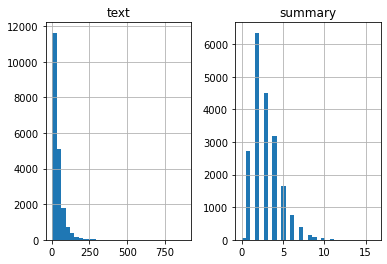

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in format_data:
      text_word_count.append(len(i.split()))

for i in format_highlight:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max_text_len=80
max_summary_len=10

In [ ]:
short_text=[]
short_summary=[]
short_val_summary=[]
short_val_text=[]
short_test_summary=[]
short_test_text=[]
for i in range(len(format_data)):
    if(len(format_highlight[i].split())<=max_summary_len and len(format_data[i].split())<=max_text_len):
        short_summary.append(format_highlight[i])
        short_text.append(format_data[i])


for i in range(len(format_val_data)):
    if(len(format_val_highlight[i].split())<=max_summary_len and len(format_val_data[i].split())<=max_text_len):
        short_val_summary.append(format_val_highlight[i])
        short_val_text.append(format_val_data[i])

for i in range(len(format_test_data)):
    if(len(format_test_highlight[i].split())<=max_summary_len and len(format_test_data[i].split())<=max_text_len):
        short_test_summary.append(format_test_highlight[i])
        short_test_text.append(format_test_data[i])
        
format_highlight=short_summary
format_data=short_text

format_val_highlight=short_val_summary
format_val_data=short_val_text

format_test_highlight=short_test_summary
format_test_data=short_test_text

In [ ]:
len(max(format_data,key=len))

567

In [ ]:
format_data[0]

'favorite time lunch lunch one packet spring vegetable soup mix one packet tomato soup sprinkle crush cracker top good also eat afternoon know go late night office want stay away snack food'

### Text Tokenizing and Padding:

In [ ]:
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
X_token=tokenizer(format_data)
sos_eos_highlight=add_start_end_token(format_highlight)
Y_token=tokenizer(sos_eos_highlight)

seq,max_len_data,ART_VOCAB_SIZE=token_fit(format_data,X_token)
seq_highlight,max_len_data_highlights,HIGH_VOCAB_SIZE=token_fit(sos_eos_highlight,Y_token)

#padded_val_seq_data, VAL_ART_VOCAB_SIZE, VAL_ART_LEN = tokenizer(format_val_data)
val_seq_data, max_len_val_data, VAL_ART_VOCAB_SIZE= token_fit(format_val_data,X_token)
sos_eos_val_highlight=add_start_end_token(format_val_highlight)
#padded_val_seq_highlight, VAL_HIGH_VOCAB_SIZE, VAL_HIGHLIGHT_LEN = tokenizer(sos_eos_val_highlight)
val_seq_highlight,max_len_val_data_highlights, VAL_HIGH_VOCAB_SIZE= token_fit(sos_eos_val_highlight,Y_token)

#padded_test_seq_data, TEST_ART_VOCAB_SIZE, TEST_ART_LEN = tokenizer(format_test_data)
test_seq_data, max_len_test_data, TEST_ART_VOCAB_SIZE= token_fit(format_test_data,X_token)
sos_eos_test_highlight=add_start_end_token(format_test_highlight)
#padded_test_seq_highlight, TEST_HIGH_VOCAB_SIZE, TEST_HIGHLIGHT_LEN = tokenizer(sos_eos_test_highlight)
test_seq_highlight, max_len_test_data_highlights, TEST_HIGH_VOCAB_SIZE= token_fit(sos_eos_test_highlight,Y_token)

global_max_len_data=max([max_len_data,max_len_val_data,max_len_test_data])
global_max_len_data_highlights=max([max_len_data_highlights,max_len_val_data_highlights,max_len_test_data_highlights])

padded_seq,ARTICLE_LEN=padding(seq,global_max_len_data)
padded_val_seq_data, VAL_ART_LEN = padding(val_seq_data,global_max_len_data)
padded_test_seq_data, TEST_ART_LEN = padding(test_seq_data,global_max_len_data)

padded_seq_highlight,HIGHLIGHT_LEN=padding(seq_highlight,global_max_len_data_highlights)
padded_val_seq_highlight, VAL_HIGHLIGHT_LEN = padding(val_seq_highlight,global_max_len_data_highlights)
padded_test_seq_highlight, TEST_HIGHLIGHT_LEN = padding(test_seq_highlight,global_max_len_data_highlights)
#print(words)

80
12
80
12
80
12


In [ ]:
global_max_highlight_vocab_size = max(HIGH_VOCAB_SIZE,VAL_HIGH_VOCAB_SIZE,TEST_HIGH_VOCAB_SIZE)

global_max_article_vocab_size = max(ART_VOCAB_SIZE,VAL_ART_VOCAB_SIZE,TEST_ART_VOCAB_SIZE)

In [ ]:
K.clear_session()  #Resets all state generated by Keras

### Creating model

In [ ]:
with tensorflow.device("/gpu:0"):
  seq2seq = MySeq2Seq(hidden_layer_dimensions,embedding_dimensions,global_max_len_data,global_max_article_vocab_size+1,global_max_len_data_highlights, global_max_highlight_vocab_size+1)

  seq2seq.create()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      1406208     input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 80, 256), (N 393984      embedding[0][0]                  
_____________________________________________________________________________________________

In [ ]:
from tensorflow.keras import callbacks
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\n Epoch {} ended".format(epoch))
        #print(seq2seq.model.layers[1].get_weights())

### Creating model

In [ ]:
#Adding Metrics
with tensorflow.device("/gpu:0"):
  seq2seq.model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

### Training and validating model

In [ ]:
with tensorflow.device("/gpu:0"):
  history = seq2seq.model.fit([padded_seq,padded_seq_highlight[:,:-1]], padded_seq_highlight.reshape(padded_seq_highlight.shape[0],padded_seq_highlight.shape[1], 1)[:,1:] ,epochs=50,callbacks=[CustomCallback()],batch_size= 64, validation_data=([padded_val_seq_data,padded_val_seq_highlight[:,:-1]], padded_val_seq_highlight.reshape(padded_val_seq_highlight.shape[0],padded_val_seq_highlight.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 17986 samples, validate on 17955 samples
Epoch 1/50
17984/17986 [============================>.] - ETA: 0s - loss: 2.0385 - acc: 0.7312
 Epoch 0 ended
17986/17986 [==============================] - 83s 5ms/sample - loss: 2.0386 - acc: 0.7312 - val_loss: 1.9197 - val_acc: 0.7449
Epoch 2/50
17984/17986 [============================>.] - ETA: 0s - loss: 1.8013 - acc: 0.7512
 Epoch 1 ended
17986/17986 [==============================] - 81s 4ms/sample - loss: 1.8013 - acc: 0.7512 - val_loss: 1.8574 - val_acc: 0.7504
Epoch 3/50
17984/17986 [============================>.] - ETA: 0s - loss: 1.7377 - acc: 0.7544
 Epoch 2 ended
17986/17986 [==============================] - 81s 4ms/sample - loss: 1.7377 - acc: 0.7544 - val_loss: 1.8075 - val_acc: 0.7475
Epoch 4/50
17984/17986 [============================>.] - ETA: 0s - loss: 1.6904 - acc: 0.7569
 Epoch 3 ended
17986/17986 [===================

### Visualization of training and validation accuracy and loss

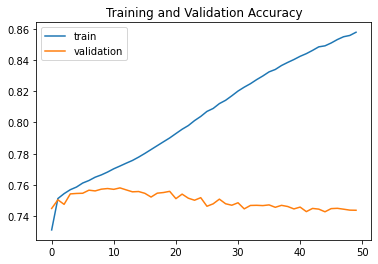

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='validation') 
pyplot.title("Training and Validation Accuracy")
pyplot.legend() 
pyplot.show()

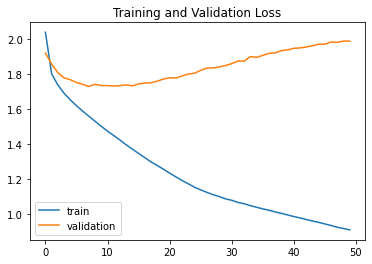

In [ ]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.title("Training and Validation Loss")
pyplot.legend() 
pyplot.show()

### Inference phase

In [ ]:
def infer_results(padded_test_seq_data):
  All_sentences = []
  for i in range(len(padded_test_seq_data)):
    # the input sequence to the encoder is the text data
    inputseq = padded_test_seq_data[i].reshape(1,global_max_len_data)
    encoder_op,encoder_c=seq2seq.encoder_testing.predict(inputseq)
    infered_op = np.zeros((1,1))

    # start token is sent to the decoder to infer outputs.
    infered_op[0,0] = 2
    decoded_sent=[]
    reverse_words = Y_token.index_word
    while True:
      decoder_op,decoder_c=seq2seq.decoder_testing.predict([infered_op]+[encoder_op,encoder_c])
      token_index=np.argmax(decoder_op[0,-1,:])
      token=reverse_words[token_index]

      if token=="<UNK>" or token=="eos" or len(decoded_sent)>=global_max_len_data_highlights:
        #break the loop if unknown or end of sequence token is reached
        break

      if token!="<UNK>" or token!="eos":
        decoded_sent.append(token)

      # for the next time step, the word infered in the previous time-step is sent as a input token.
      infered_op[0,0]  = token_index

      # state variables are set to pervious time step data for encoding.
      encoder_c=decoder_c

    sent = " ".join(decoded_sent)
    All_sentences.append(sent)
  return All_sentences
All_sentences = infer_results(padded_test_seq_data)

### Rouge Metric:

We have used Rouge score to compare the predicted summary and the actual summary to find the Precision, Recall and F1 scores.

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
# Calculation of Precision, Recall, f1 score from Rouge1 scores generated. 
# We have displayed the avergae of all these metrics.

presicion = []
recall = []
f1 = []
print(len(All_sentences))
for (h, r) in zip(All_sentences, format_test_highlight):
    if h != "" and r != "":
      score = rouge.get_scores(h, r)
      # print(score)
      s = score[0]['rouge-1']
      presicion.append(s["p"])
      recall.append(s["r"])
      f1.append(s["f"])

print("Presicion:",sum(presicion)/len(presicion))
print("Recall:", sum(recall)/len(recall))
print("F1:",sum(f1)/len(f1))

18017
Presicion: 0.12566400506263112
Recall: 0.10725012341936768
F1: 0.10981405649953728


### Inferred results visualization

Following cells show some good examples of text summerization as well as some failed examples on Amazon dataset.

##### Some Good examples:

In [ ]:
index = 100
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   come across compel reason online add daily nutritional supplement buy product tell open jar skedish down tablespoon stuff first add oatmeal actually enhance flavor next move allow liquefy down tablespoon right jar delight wonderful taste
Actual Highlights:   wonderful flavor smell and consistency
Predicted HIghlighs:  the perfect food


In [ ]:
index = 2682
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   like vitacoco drink crazy acai pomegranate flavor others otherwise satisfy healthy refreshing
Actual Highlights:   good drink
Predicted HIghlighs:  not bad great


In [ ]:
index = 4411
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   love peanut sauce kick find one local grocery store without home ever since but grocery store start stock sporadically search amazon com found could buy great addition great many dish put celery snack rice flavor booster chicken recommend
Actual Highlights:   the best
Predicted HIghlighs:  fantastic product


In [ ]:
index = 10569
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   friend party find looked first good little pricey get buy good
Actual Highlights:   yum
Predicted HIghlighs:  best


In [ ]:
index = 14484
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   order twice year the come excellent condition within day order
Actual Highlights:   great product great service seller
Predicted HIghlighs:  excellent product


In [ ]:
index = 6888
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   get scream deal buying store would order price
Actual Highlights:   awesome deal
Predicted HIghlighs:  great product


##### Some Failed examples:

In [ ]:
index = 21
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   for anyone never eat mind blown especially eat brand pop tart use artificial flavor color preservative gmos bad these taste well better they make real ingredient feel sorry never try continue eat brand you be miss out it win win situation would nice buy keep mind grocery store health food store find walmart you find many place nature path one best organic company top great support
Actual Highlights:   you cannot wrong
Predicted HIghlighs:  cannot live without


In [ ]:
index = 87
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   bully stick expensive store when saw deal think great value worry would thinner good quality great stuff would pet store dog love know keep always get excited every time open closet door cannot want another bully stick
Actual Highlights:   dog love thing
Predicted HIghlighs:  best price find


In [ ]:
index = 985
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   these jelly bean small big taste find laugh taste much like real thing some flavor totally shock cappuccino juicy pear cantaloupe peach margarita taste like real thing they fresh soft they also come jelly belly chart back container show picture jelly beans description wonderful deal sale buy another
Actual Highlights:   wow taste like real thing
Predicted HIghlighs:  not


In [ ]:
index = 14517
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   these treat month old boston terrier favorite treat far give natural treat wheat ton add filler know house happy give something else
Actual Highlights:   boston favorite
Predicted HIghlighs:  the dog love


In [ ]:
index = 1597
print("Article:  ",format_test_data[index])
print("Actual Highlights:  ",format_test_highlight[index])
print("Predicted HIghlighs: ",All_sentences[index])

Article:   annie deluxe macaroni cheese quick prepare tasty speedy meal sometimes add cubed ham peas package another option bulk pricing amazon plus
Actual Highlights:   annie deluxe macaroni cheese
Predicted HIghlighs:  never enough without sugar
